In [1]:
from keras.models   import Model
from keras.layers   import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, LeakyReLU
from keras.utils    import plot_model
from keras.datasets import mnist

from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing     import OneHotEncoder

import h5py

import numpy  as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image 

%matplotlib inline

Using TensorFlow backend.


# CNN model for MNIST data 

## Load data

In [2]:
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = mnist.load_data()

x_train = np.reshape( 
    (x_train_orig.astype('float32') / 255.), 
    (len(x_train_orig), x_train_orig.shape[1], x_train_orig.shape[2], 1) 
)

x_test  = np.reshape( 
    (x_test_orig.astype('float32')  / 255.), 
    (len(x_test_orig),  x_test_orig.shape[1],  x_test_orig.shape[2],  1) 
)

y_train = OneHotEncoder(sparse=False,categories='auto').fit_transform(y_train_orig.reshape(-1, 1))
y_test  = OneHotEncoder(sparse=False,categories='auto').fit_transform(y_test_orig.reshape(-1, 1))

## CNN Model

```python
model = Sequential()
model.add( Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28,28,1)) )
model.add( MaxPooling2D() )
model.add( Dropout(0.2) )
model.add( Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same') )
model.add( MaxPooling2D() )
model.add( Dropout(0.2) )
model.add( Flatten() )
model.add( Dense(32,  activation='relu')
model.add( Dense(10,  activation='softmax') )
```

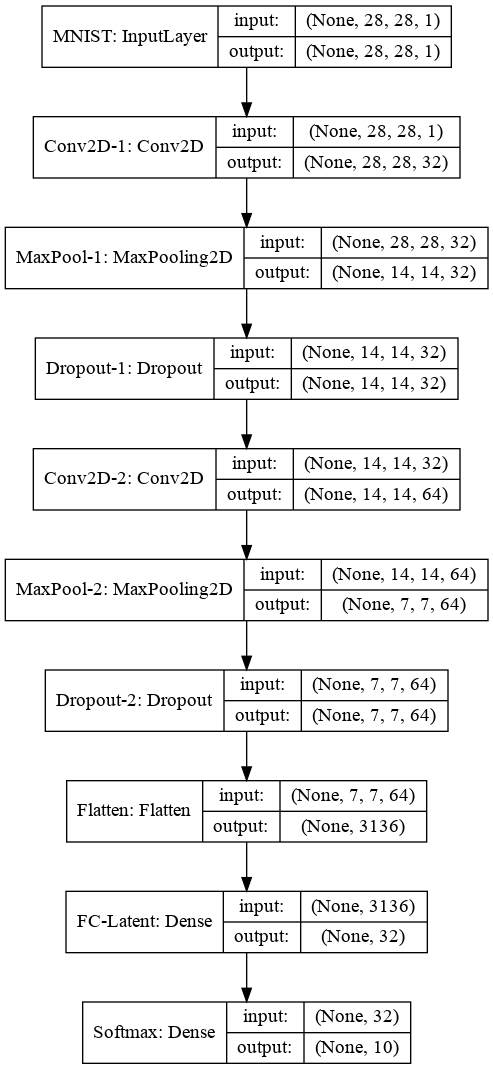

In [3]:
mnist_inputs = Input(name='MNIST', shape=(28,28,1,))

x1 = mnist_inputs
x1 = Conv2D( 32, kernel_size=(3, 3),
    activation='relu', padding='same', name='Conv2D-1' )(x1)
x1 = MaxPooling2D(                     name='MaxPool-1')(x1)
x1 = Dropout(0.2,                      name='Dropout-1'  )(x1)
x1 = Conv2D( 64, kernel_size=(3, 3),
    activation='relu', padding='same', name='Conv2D-2' )(x1)
x1 = MaxPooling2D(                     name='MaxPool-2')(x1)
x1 = Dropout(0.2,                      name='Dropout-2'  )(x1)
x1 = Flatten(                          name='Flatten'  )(x1)
x1 = Dense(32,  activation='relu',     name='FC-Latent')(x1)
x1 = Dense(10,  activation='softmax',  name='Softmax'  )(x1)
mnist_pred = x1

mnist_cnn_model = Model(inputs=mnist_inputs, outputs=mnist_pred, name='MNIST_CNN')

plot_model(mnist_cnn_model, show_shapes=True, to_file='mnist_cnn_model.png')
Image(filename='mnist_cnn_model.png',retina=True)

## Train & validation

In [4]:
mnist_cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer='adadelta',
    metrics=['accuracy']
)

history = mnist_cnn_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=128,
    shuffle=True, 
    verbose=2,
)

print ()
score = mnist_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:',     score[0])
print('Test accuracy:', score[1])

mnist_cnn_model.save('mnist_cnn_model.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 16s - loss: 0.2807 - acc: 0.9102 - val_loss: 0.0790 - val_acc: 0.9750
Epoch 2/10
 - 16s - loss: 0.0804 - acc: 0.9754 - val_loss: 0.0568 - val_acc: 0.9813
Epoch 3/10
 - 16s - loss: 0.0612 - acc: 0.9807 - val_loss: 0.0385 - val_acc: 0.9876
Epoch 4/10
 - 16s - loss: 0.0489 - acc: 0.9846 - val_loss: 0.0445 - val_acc: 0.9858
Epoch 5/10
 - 16s - loss: 0.0420 - acc: 0.9868 - val_loss: 0.0338 - val_acc: 0.9882
Epoch 6/10
 - 16s - loss: 0.0369 - acc: 0.9882 - val_loss: 0.0324 - val_acc: 0.9890
Epoch 7/10
 - 16s - loss: 0.0323 - acc: 0.9896 - val_loss: 0.0290 - val_acc: 0.9902
Epoch 8/10
 - 16s - loss: 0.0301 - acc: 0.9903 - val_loss: 0.0295 - val_acc: 0.9901
Epoch 9/10
 - 16s - loss: 0.0268 - acc: 0.9914 - val_loss: 0.0318 - val_acc: 0.9893
Epoch 10/10
 - 16s - loss: 0.0246 - acc: 0.9921 - val_loss: 0.0260 - val_acc: 0.9921

Test loss: 0.02599905670255248
Test accuracy: 0.9921


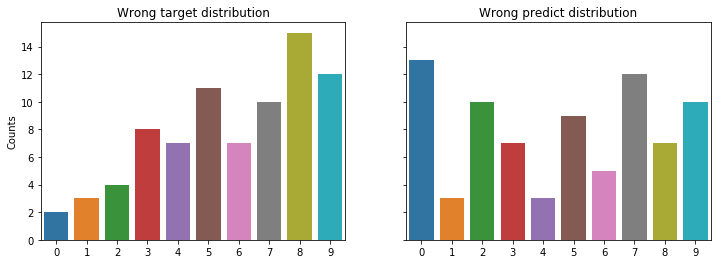

In [5]:
data1 = []
data2 = []

pred = np.argmax(mnist_cnn_model.predict(x_test), axis=1)

for index in np.where(pred != y_test_orig)[0]:
    data1.append(y_test_orig[index])
    data2.append(pred[index])

data1 = pd.Series(data1).value_counts().sort_index().reindex(range(0,10)).fillna(0).reset_index()
data2 = pd.Series(data2).value_counts().sort_index().reindex(range(0,10)).fillna(0).reset_index()

# plt.figure(figsize=(16,8))
fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=True)

sns.barplot(data=data1,x='index',y=0, ax=ax[0])
ax[0].set_title('Wrong target distribution')
ax[0].set_xlabel('')
ax[0].set_ylabel('Counts')

sns.barplot(data=data2,x='index',y=0, ax=ax[1])
ax[1].set_title('Wrong predict distribution')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

plt.show();

In [6]:
# import holoviews as hv

# pred = np.argmax(mnist_cnn_model.predict(x_test), axis=1)

# sankey_data = pd.concat(
#     [
#         pd.Series(y_test_orig),
#         pd.Series(pred),
#     ], axis=1).rename(columns={0:'Target',1:'Predicted'}).assign(Counts=1)

# sankey_summary = pd.DataFrame(columns=sankey_data.columns)

# for i,df_1 in sankey_data.groupby('Target'):
#     for j,df_2 in df_1.groupby('Predicted'):
#         sankey_summary = sankey_summary.append({'Target':'T'+str(i), 'Predicted':'P'+str(j), 'Counts':min(df_2['Counts'].sum(),1e10)},ignore_index=True)

# hv.Sankey(sankey_summary.values)

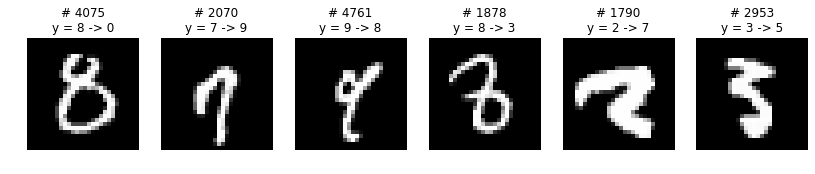

In [7]:
plt.figure(figsize=(14,6))

for i,index in enumerate(np.random.choice(np.where(pred != y_test_orig)[0],6)):
    plt.subplot(1,6,i+1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    plt.title(
        '# ' + str(index) + '\n' + 
        'y = ' + str(y_test_orig[index]) + 
        ' -> ' + str(pred[index]) 
    )

plt.show();

---
---
---

# CNN model for N-signs
- Datasets: https://www.floydhub.com/deeplearningai/datasets/signs
- Github: https://github.com/mesolmaz/HandSigns_CNN
- Others: https://stats.stackexchange.com/questions/311831/why-does-vgg16-double-number-of-features-after-each-maxpooling-layer

***Warnings***

> Small dataset! Work well in CNN, but not work well in Autoencoder



## Load data

In [8]:
f1 = h5py.File("train_signs.h5", "r")
f2 = h5py.File("test_signs.h5",  "r")

# Loading the data (signs)
X_train_orig = np.array(f1['train_set_x'])
Y_train_orig = np.array(f1['train_set_y'])
X_test_orig  = np.array(f2['test_set_x'])
Y_test_orig  = np.array(f2['test_set_y'])

# print ("Training Data Feature Size = " + str(X_train_orig.shape))
# print ("Training Data Class Size = " + str(Y_train_orig.shape))
# print ("Test Data Feature Size = " + str(X_test_orig.shape))
# print ("Test Data Class Size = " + str(Y_test_orig.shape))

X_train = (X_train_orig / 255).astype('float32')
X_test  = (X_test_orig  / 255).astype('float32')

test_datagen  = ImageDataGenerator( rescale=1./255, )
train_datagen = ImageDataGenerator( rescale=1./255,
    width_shift_range  = 0.1,
    height_shift_range = 0.1,
    shear_range        = 0.7,
    zoom_range         = 0.1,
    rotation_range     = 25,
    horizontal_flip    = True,
    vertical_flip      = False,
    fill_mode          = 'nearest',
)

train_datagen.fit(X_train_orig)
test_datagen.fit(X_test_orig)


Y_train = OneHotEncoder(sparse=False,categories='auto').fit_transform(Y_train_orig.reshape(-1, 1))
Y_test  = OneHotEncoder(sparse=False,categories='auto').fit_transform(Y_test_orig.reshape(-1, 1))

# (Y_train.argmax(axis=1) == Y_train_orig).all()

# print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of test examples = " + str(X_test.shape[0]))
# print ("X_train shape: " + str(X_train.shape))
# print ("Y_train shape: " + str(Y_train.shape))
# print ("X_test shape: " + str(X_test.shape))
# print ("Y_test shape: " + str(Y_test.shape))

# # Example of a picture
# index = 1
# plt.imshow(X_train_orig[index])
# print ("y = " + str(Y_train_orig[index]))

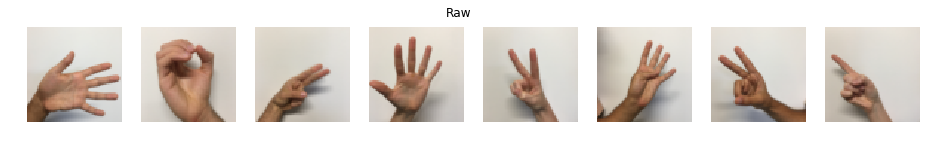

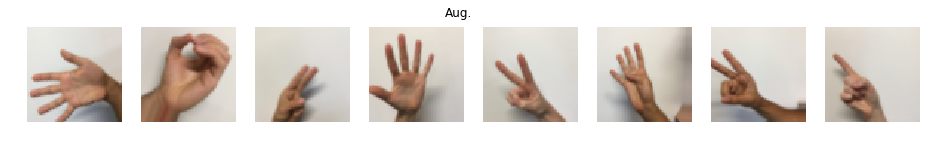

In [9]:
data_iter = train_datagen.flow(X_train_orig, batch_size=8, shuffle=False)

x_batch = data_iter.next()

plt.figure(figsize=(16,8))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X_train_orig[i].reshape(64,64,3), cmap='gray')
    plt.axis('off')
plt.suptitle('Raw',y=0.62)
plt.show()


plt.figure(figsize=(16,8))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(x_batch[i].reshape(64,64,3), cmap='gray')
    plt.axis('off')
plt.suptitle('Aug.',y=0.62)
plt.show()

## CNN Model


```python
model = Sequential()
model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64,64,3)) )
model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64,64,3)) )
model.add( MaxPooling2D() )
model.add( Dropout(0.4) )
model.add( Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',) )
model.add( Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',) )
model.add( MaxPooling2D() )
model.add( Dropout(0.4) )
model.add( Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',) )
model.add( Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',) )
model.add( MaxPooling2D() )
model.add( Dropout(0.2) )
model.add( Flatten() )
model.add( Dense(512, activation='relu') )
model.add( Dense(6,   activation='softmax') )
```

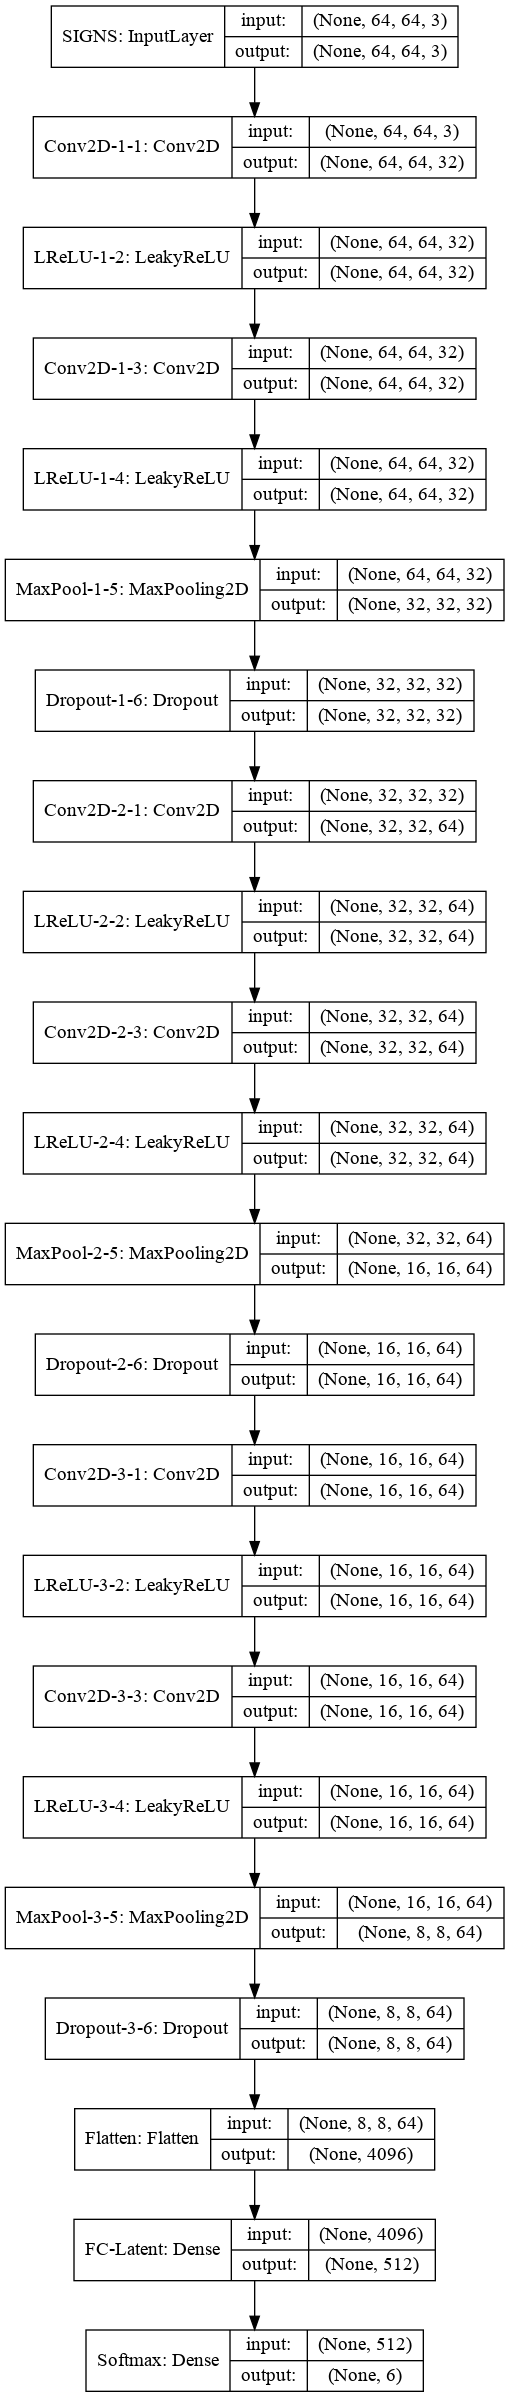

In [10]:
signs_inputs = Input(name='SIGNS', shape=(64,64,3,))

x2 = signs_inputs
x2 = Conv2D( 32, kernel_size=3, padding='same', name='Conv2D-1-1' )(x2)
x2 = LeakyReLU(                                 name='LReLU-1-2'  )(x2)
x2 = Conv2D( 32, kernel_size=3, padding='same', name='Conv2D-1-3' )(x2)
x2 = LeakyReLU(                                 name='LReLU-1-4'  )(x2)
x2 = MaxPooling2D(                              name='MaxPool-1-5')(x2)
x2 = Dropout(0.4,                               name='Dropout-1-6')(x2)

x2 = Conv2D( 64, kernel_size=3, padding='same', name='Conv2D-2-1' )(x2)
x2 = LeakyReLU(                                 name='LReLU-2-2'  )(x2)
x2 = Conv2D( 64, kernel_size=3, padding='same', name='Conv2D-2-3' )(x2)
x2 = LeakyReLU(                                 name='LReLU-2-4'  )(x2)
x2 = MaxPooling2D(                              name='MaxPool-2-5')(x2)
x2 = Dropout(0.4,                               name='Dropout-2-6')(x2)

x2 = Conv2D( 64, kernel_size=3, padding='same', name='Conv2D-3-1' )(x2)
x2 = LeakyReLU(                                 name='LReLU-3-2'  )(x2)
x2 = Conv2D( 64, kernel_size=3, padding='same', name='Conv2D-3-3' )(x2)
x2 = LeakyReLU(                                 name='LReLU-3-4'  )(x2)
x2 = MaxPooling2D(                              name='MaxPool-3-5')(x2)
x2 = Dropout(0.2,                               name='Dropout-3-6')(x2)

x2 = Flatten(                                   name='Flatten'    )(x2)
x2 = Dense(512, activation='relu',              name='FC-Latent'  )(x2)
x2 = Dense(6,   activation='softmax',           name='Softmax'    )(x2)
signs_pred = x2

signs_cnn_model = Model(inputs=signs_inputs, outputs=signs_pred, name='SIGNS_CNN')

plot_model(signs_cnn_model, show_shapes=True, to_file='signs_cnn_model.png')
Image(filename='signs_cnn_model.png',retina=True)

In [11]:
# signs_inputs = Input(name='SIGNS', shape=(64,64,3,))

# x2 = signs_inputs
# x2 = Conv2D( 32, kernel_size=(3, 3),  
#     activation='relu', padding='same', name='Conv2D-1-1' )(x2)
# x2 = Conv2D( 32, kernel_size=(3, 3),  
#     activation='relu', padding='same', name='Conv2D-1-2' )(x2)
# x2 = MaxPooling2D(                     name='MaxPool-1-3')(x2)
# x2 = Dropout(0.4,                      name='Dropout-1-4')(x2)
# x2 = Conv2D( 64, kernel_size=(3, 3),  
#     activation='relu', padding='same', name='Conv2D-2-1' )(x2)
# x2 = Conv2D( 64, kernel_size=(3, 3),  
#     activation='relu', padding='same', name='Conv2D-2-2' )(x2)
# x2 = MaxPooling2D(                     name='MaxPool-2-3')(x2)
# x2 = Dropout(0.4,                      name='Dropout-2-4')(x2)
# x2 = Conv2D( 64, kernel_size=(3, 3),  
#     activation='relu', padding='same', name='Conv2D-3-1' )(x2)
# x2 = Conv2D( 64, kernel_size=(3, 3),  
#     activation='relu', padding='same', name='Conv2D-3-2' )(x2)
# x2 = MaxPooling2D(                     name='MaxPool-3-3')(x2)
# x2 = Dropout(0.2,                      name='Dropout-3-4')(x2)
# x2 = Flatten(                          name='Flatten'    )(x2)
# x2 = Dense(512, activation='relu',    name='FC-1'        )(x2)
# x2 = Dense(6,   activation='softmax', name='Softmax'     )(x2)
# signs_pred = x2

# signs_cnn_model = Model(inputs=signs_inputs, outputs=signs_pred, name='SIGNS_CNN')

# plot_model(signs_cnn_model, show_shapes=True, to_file='signs_cnn_model.png')
# Image(filename='signs_cnn_model.png',retina=True)

In [12]:
signs_cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer='adadelta',
    metrics=['accuracy']
)

history = signs_cnn_model.fit_generator(
    train_datagen.flow(X_train_orig, Y_train, batch_size=32, shuffle=True),
    validation_data=(X_test, Y_test),
    epochs=30,
    use_multiprocessing=True,
    verbose=2,
)

print ()
score = signs_cnn_model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:',     score[0])
print('Test accuracy:', score[1])

signs_cnn_model.save('signs_cnn_model.h5')

Epoch 1/30
 - 11s - loss: 1.8461 - acc: 0.1734 - val_loss: 1.7905 - val_acc: 0.1667
Epoch 2/30
 - 10s - loss: 1.7950 - acc: 0.1743 - val_loss: 1.7867 - val_acc: 0.2167
Epoch 3/30
 - 10s - loss: 1.8005 - acc: 0.1832 - val_loss: 1.7831 - val_acc: 0.2333
Epoch 4/30
 - 10s - loss: 2.0581 - acc: 0.2190 - val_loss: 1.7400 - val_acc: 0.1917
Epoch 5/30
 - 9s - loss: 1.6789 - acc: 0.2892 - val_loss: 1.4624 - val_acc: 0.5333
Epoch 6/30
 - 10s - loss: 1.5098 - acc: 0.4007 - val_loss: 1.4235 - val_acc: 0.4333
Epoch 7/30
 - 10s - loss: 1.3895 - acc: 0.4801 - val_loss: 1.3030 - val_acc: 0.4083
Epoch 8/30
 - 10s - loss: 1.1752 - acc: 0.5404 - val_loss: 0.6876 - val_acc: 0.7500
Epoch 9/30
 - 10s - loss: 1.0215 - acc: 0.6020 - val_loss: 0.6932 - val_acc: 0.7083
Epoch 10/30
 - 10s - loss: 0.8483 - acc: 0.6872 - val_loss: 0.3825 - val_acc: 0.8417
Epoch 11/30
 - 10s - loss: 0.7165 - acc: 0.7378 - val_loss: 0.5352 - val_acc: 0.7833
Epoch 12/30
 - 10s - loss: 0.6325 - acc: 0.7807 - val_loss: 0.4026 - val_ac

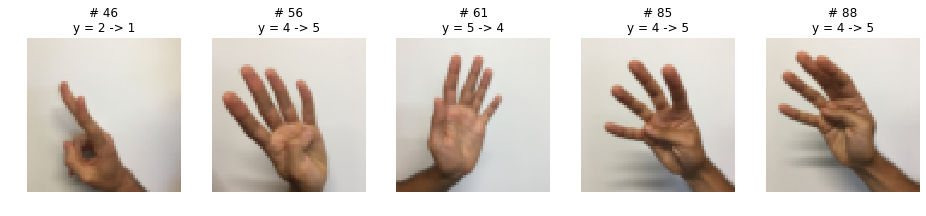

In [13]:
# # Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper right')
# plt.show()
        
pred = np.argmax(signs_cnn_model.predict(X_test), axis=1)
n_wrong = np.where(pred != Y_test_orig)[0].shape[0]
plt.figure(figsize=(16,n_wrong))

for i,index in enumerate(np.where(pred != Y_test_orig)[0]):
    plt.subplot(1,n_wrong,i+1)
    plt.imshow(X_test_orig[index])
    plt.gray()
    plt.axis('off')
    plt.title(
        '# ' + str(index) + '\n' + 
        'y = ' + str(Y_test_orig[index]) + 
        ' -> ' + str(pred[index]) 
    )

plt.show();

---
---
---